### Data Mining the PDB
Robert Palmere, 2021\
email: rdp135@chem.rutgers.edu


In [4]:
from pypdb import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Perhaps we are interested in which residues are most likely to be solvent exposed across the span of proteins related to membranes.

Our code will need to:

1. Acquire data from the PDB
2. Render Python handles to textual data of the PDB
3. Make calculations based on a user-defined function

Let's write a function to handle the parsing of PDB file text.

In [4]:
def floatcustom(s: str):
    '''Function to cast string to float with exception for unseparated coordinate values
    i.e. '-153.534-108.134' returns [-153.534, -108.134]
    
    Parameters:
    -----------
    s : str
        string that should have been parsed properly but PDB didn't account for '-'
    '''
    try:
         return float(s)
    except:
        indices = []
        floats_ = []
        for index, char in enumerate(s): 
            if char == '-':
                indices.append(index)
        if len(indices) > 1 and ' ' not in s:
            for n, i in enumerate(indices):
                if n >= 1:
                    floats_.append(float(s[indices[n-1]:indices[n]]))
            floats_.append(float(s[indices[-1]:]))
        return floats_

In [5]:
# Example usage of floatcustom():

print(floatcustom('-153.534-108.134'))

[-153.534, -108.134]


In [6]:
def checkflattened(l: list):
    '''Specific function for handling output from customfloat() - ensures list is flattened if it contains
        a sublist and removes last element from different column
    '''
    flattened_ = []
    contains_sublist = False
    for i in l:
        if isinstance(i, list):
            contains_sublist = True
            for j in i:
                flattened_.append(j)
        else:
            flattened_.append(i)
    if contains_sublist:
        del flattened_[-1]
    return flattened_

In [7]:
# Example usage of checkflattened():

test_list = ['1', ['2', '3'], '4']
checkflattened(test_list)

['1', '2', '3']

In [8]:
def pdbParser(pdbtext: str) -> dict:
    '''Returns two dictionaries associated with basic info for the PDB and the PDB atom information
    
    Parameters
    ----------
    pdbtext : str
        The full text of a PDB provided as a string

    '''
    info_ = {
            'HEADER' : None,
            'TITLE' : None, # Will hold lists to be subsequently parsed
            'SOURCE' : [],
            'REMARKS' : [], # a = np.genfromtxt() ; import pandas as pd ; pd.DataFrame(a)
            }
    protein_ = {'ATOM' : [], 'HETATM' : []} # Will hold lists to be subsequently parsed
    listofstrings = pdbtext.split('\n')
    listofstrings = [' '.join(substring.split()) for substring in listofstrings] # make only space separated
    for substring in listofstrings:
        split = substring.split(' ')
        if split[0] in tuple(info_.keys()):
            if split[0] == 'HEADER' or split[0] == 'TITLE':
                info_[split[0]] = split[1:]
            else:
                info_[split[0]].append(split[1:])
        elif split[0] in protein_.keys():
            xyz = checkflattened([floatcustom(i) for i in split[6:9]])
            if len(xyz) != 3:
                return None
            p_ = {
                'serial' : split[1],
                'name' : split[2],
                'resname' : split[3],
                'chain' : split[4],
                'resid' : split[5],
                'xyz' : checkflattened([floatcustom(i) for i in split[6:9]])
                 }
            protein_[split[0]].append(p_)
    return info_, protein_

Next, we will write a function to acquire data from the PDB without downloading the files.

In [8]:
def getData(key: str, index=None, plot=False) -> list: # <-- Notice the Python3.x new syntax for type hints
    '''Returns relevant data for proteins associated with the provided key
    
    Parameters
    ----------
    key : str
        The category supplied for PDB searches
        
    index (optional): int or None (default: None)
        The index of a single PDBs to extract data from
        
    plot (optional): bool (default: False)
        Boolean to decide whether to plot the protein or not (Note: index must be an int)
    
    Raises
    ------
    ValueError
        Raised if the provided key cannot be converted to a string.
        Raised if 'index' keyword argument is not an integer.
    '''
    try:
        key = str(key)
    except:
        raise ValueError('Key must be able to be cast as a string literal.')
    if plot == True:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    pdb_entries = Query(key)
    pdb_entries = pdb_entries.search()
    if index != None and isinstance(index, int):
        pdb = get_pdb_file(pdb_entries[index])
        info, protein = pdbParser(pdb)
        coords = [atom['xyz'] for atom in protein['ATOM']]
        if plot == True:
            c = np.asarray(coords)
            ax.plot(c[:, 0], c[:, 1], c[:, 2], lw=0.5)
        plt.show()
    elif index == None:
        for i in range(pdb_entries):
            pdb = get_pdb_file(pdb_entries[i])
            info, protein = pdbParser(pdb)
    else:
        raise ValueError('index keyword must be an integer.')

getData('actin', index=12, plot=True)
#getData('peripheral membrane', index=1, plot=True)

/Users/rdp135/opt/miniconda3/lib/python3.9/site-packages/pypdb/util/http_requests.py:61: UserWarning: Too many failures on requests. Exiting...
  warnings.warn("Too many failures on requests. Exiting...")


AttributeError: 'NoneType' object has no attribute 'status_code'

AttributeError: module 'PIL.Image' has no attribute 'Resampling'

<Figure size 432x288 with 1 Axes>

In [23]:
import pypdb
print(dir(pypdb))

['Counter', 'OrderedDict', 'Query', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'chain', 'describe_pdb', 'find_papers', 'find_results_gen', 'get_all_info', 'get_entity_info', 'get_info', 'get_pdb_file', 'http_requests', 'json', 'pypdb', 're', 'remove_at_sign', 'remove_dupes', 'repeat', 'requests', 'time', 'to_dict', 'util', 'walk_nested_dict', 'warnings']


We want to know which residues are most prevalent on the outer portions of the protein. Let's write a function which takes in coordinates (ignoring vdW radii) and renders a ranking of residues which are "solvent exposed".

There are other (and much more accurate) ways of doing this (SASA), but for this demonstration we will simply use the distance from the geometric center of the protein as our metric. We will take the top 5% of the residues (threshold value) that are farthest from the center and consider them to be the most solvent exposed.

In [12]:
def getSolventExposed(protein, threshold=5):
    '''Returns a dictionary containing residue names and the number of atoms on the outer portion of the protein
    
    Parameters
    ----------
    protein : dict
        dictionary containing protein PDB information produced by pdbParser()
        
    threshold (optional): float (default: 5)
        the top percent of residues which qualify as the most exposed
        
    '''
    c = np.stack(np.asarray([np.asarray(atom['xyz']) for atom in protein['ATOM']]), axis=0)
    resname_list = np.asarray([atom['resname'] for atom in protein['ATOM']])
    center = (np.average(np.asarray(c)[:, 0]), np.average(np.asarray(c)[:, 1]), np.average(np.asarray(c)[:, 2]))
    distance = lambda c_tuple : np.sqrt((c_tuple[0]-center[0])**2 + (c_tuple[1]-center[1])**2 + (c_tuple[2]-center[2])**2)
    distances = np.asarray([distance(coord) for n, coord in enumerate(c)])
    indices = np.argsort(distances)[::-1] # sort from highest to lowest distance - return the indices
    resname_sorted = resname_list[indices]
    distances_sorted = distances[indices]
    percent = 0
    top_residues = []
    for r in resname_sorted:
        percent += 1/len(resname_sorted) * 100
        top_residues.append(r)
        if percent >= threshold:
            break
    d_ = {i:top_residues.count(i) for i in top_residues} # Unique resnames : # of atoms
    return d_

Let's now add this function to our getData function.

First, we will need to write a function to add dictionaries key-wise.

In [16]:
def addDictKeys(dtarget, add):
    '''Function to add to a dictionary by key-value pair
    
    Parameters:
    -----------
    dtarget : target dictionary to add to
    add : the dictionary we are adding
    '''
    for addkey in tuple(add.keys()):
        if addkey in dtarget.keys():
            dtarget[addkey] += add[addkey]
        else:
            dtarget.update({'{}'.format(addkey) : add[addkey]})

In [17]:
# Example of how addDictKeys() is used:

d1 = {'one' : 1, 'two' : 2, 'three' : 3}
d2 = {'one' : 10, 'two' : 10, 'three' : 10}

addDictKeys(d1, d2)

print(d1)

{'one': 11, 'two': 12, 'three': 13}


In [15]:
def getData(key: str, index=None, plot=False) -> dict: # <-- Notice the Python3.x new syntax for type hints
    '''Returns dictionary containing a sum of the top x% solvent exposed residues by atom count
    
    Parameters
    ----------
    key : str
        The category supplied for PDB searches
        
    index (optional): int or None (default: None)
        The index of a single PDBs to extract data from
        
    plot (optional): bool (default: False)
        Boolean to decide whether to plot the protein or not (Note: index must be an int)
    
    Raises
    ------
    ValueError
        Raised if the provided key cannot be converted to a string.
        Raised if 'index' keyword argument is not an integer.
    '''
    dataDict = {}
    try:
        key = str(key)
    except:
        raise ValueError('Key must be able to be cast as a string literal.')
    if plot == True:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    pdb_entries = Query(key).search()
    if index != None and isinstance(index, int):
        pdb = get_pdb_file(pdb_entries[index])
        info, protein = pdbParser(pdb)
        coords = [atom['xyz'] for atom in protein['ATOM']]
        if plot == True:
            c = np.asarray(coords)
            ax.plot(c[:, 0], c[:, 1], c[:, 2], lw=0.5)
        plt.show()
        exposedDict = getSolventExposed(protein)
        addDictKeys(dataDict, exposedDict)
    elif index == None:
        for i in range(pdb_entries):
            pdb = get_pdb_file(pdb_entries[i])
            info, protein = pdbParser(pdb)
    else:
        raise ValueError('index keyword must be an integer.')
    return dataDict

In [18]:
import time
start = time.time()
data = getData('integral membrane', index=12)
end = time.time()
print('Time required for a single protein: {} seconds'.format(end - start))

integral membrane


AttributeError: 'NoneType' object has no attribute 'status_code'

Let's do a quick profiling of the time this function takes before we run it on >200,000 proteins.

In [19]:
dtimes = []
total = 50
while len(dtimes) <= total:
    print('{}% completed.'.format(round((len(dtimes)/total)* 100)), end='\r')
    start = time.time()
    getData('integral membrane', index=12)
    stop = time.time()
    dtimes.append(stop-start)

integral membrane


AttributeError: 'NoneType' object has no attribute 'status_code'

/Users/rdp135/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/rdp135/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


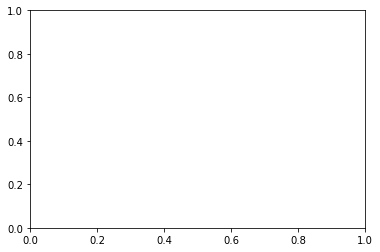

Averge time (for the tested protein size): nan


In [20]:
import seaborn as sns
fig, ax = plt.subplots()
sns.kdeplot(dtimes, ax=ax)
ax.axvline(x=np.average(dtimes), color='r')
plt.show()
print(f'Averge time (for the tested protein size): {np.average(dtimes)}')

So if we will run this code for the >200,000 proteins we plan to run it on it would take at least:

In [ ]:
print('{} days.'.format(200_000 * np.average(dtimes) / 3600 / 24))

We need to speed this up in order to gather the results in a timely fashion.

There are a couple of ways to speed code up:

1. Throw more cores at it (parallelization)
2. Vectorize the code (use numpy as much as possible)
3. Cythonize
4. Stop using Python all together in favor of a mid-level programming language (C/C++)
5. Profile and modify our algorithms

We should take the time to narrow down where our code is bottle-necking. In other words, we should take the time to see where our code is not fully optimized within Python.

We can do this systematically (https://docs.python.org/3/library/profile.html).

In [21]:
import cProfile, pstats, io

def profile(f):
    '''Decorator using cProfile to profile a given function
    '''
    def inner(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        v = f(*args, **kwargs)
        pr.disable()
        stream = io.StringIO()
        ps = pstats.Stats(pr, stream=stream).sort_stats('cumulative')
        ps.print_stats()
        print(stream.getvalue())
        return v
    return inner

In [23]:
@profile
def getData(key: str, index=None, plot=False) -> dict:
    '''Returns dictionary containing a sum of the top x% solvent exposed residues by atom count
    
    Parameters
    ----------
    key : str
        The category supplied for PDB searches
        
    index (optional): int or None (default: None)
        The index of a single PDBs to extract data from
        
    plot (optional): bool (default: False)
        Boolean to decide whether to plot the protein or not (Note: index must be an int)
    
    Raises
    ------
    ValueError
        Raised if the provided key cannot be converted to a string.
        Raised if 'index' keyword argument is not an integer.
    '''
    dataDict = {}
    try:
        key = str(key)
    except:
        raise ValueError('Key must be able to be cast as a string literal.')
    if plot == True:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    pdb_entries = pypdb.Query(key).search()
    if index != None and isinstance(index, int):
        pdb = get_pdb_file(pdb_entries[index])
        info, protein = pdbParser(pdb)
        coords = [atom['xyz'] for atom in protein['ATOM']]
        if plot == True:
            c = np.asarray(coords)
            ax.plot(c[:, 0], c[:, 1], c[:, 2], lw=0.5)
        plt.show()
        exposedDict = getSolventExposed(protein)
        addDictKeys(dataDict, exposedDict)
    elif index == None:
        for i in range(pdb_entries):
            pdb = get_pdb_file(pdb_entries[i])
            info, protein = pdbParser(pdb)
            exposedDict = getSolventExposed(protein)
            addDictKeys(dataDict, exposedDict)
    else:
        raise ValueError('index keyword must be an integer.')
    return dataDict

getData('integral membrane', index=12);

AttributeError: 'NoneType' object has no attribute 'status_code'

From here we can see that most of the time of our function is taken in retrieving the information from the PDB. If we wanted this code to run faster, we could first download all the required PDB file text locally and then optimize.

Additionally, we can parallelize this code using Python's *multiprocessing* library.

Tasks to make this more feasible:

1. Download a subset of PDBs for benchmarking purposes
2. Optimize
3. Parallelize

#### 1. Write a function to download a subset of PDBs to current working directory

In [30]:
import os

def downloadPDBs(key: str, reduced=True, amount=10):
    os.mkdir(os.getcwd()+'/'+key)
    pdb_entries = Query(key).search()
    if reduced:
        pdb_entries = pdb_entries[:amount] # Get first 10
        for i in pdb_entries:
            try:
                pdbstring = get_pdb_file(i)
                file_str = os.getcwd()+'/'+key+'/'+i+'.pdb'
                with open(file_str, 'w') as fp:
                    fp.write(pdbstring)
            except:
                continue

    else:
        for i in pdb_entries:
            try:
                pdbstring = get_pdb_file(i)
                file_str = os.getcwd()+'/'+key+'/'+i+'.pdb'
                with open(file_str, 'w') as fp:
                    fp.write(pdbstring)
            except:
                continue

In [31]:
downloadPDBs('integral membrane');
downloadPDBs('peripheral membrane');

AttributeError: 'NoneType' object has no attribute 'status_code'

Let's check the speed of our "getData" function after modifying it for extracting from local .pdb files.

In [32]:
import os # <-- import for getting all files from local directories

def getData(key: str, index=None, plot=False) -> dict:
    '''Returns dictionary containing a sum of the top x% solvent exposed residues by atom count
    
    Parameters
    ----------
    key : str
        The category supplied for PDB searches
        
    index (optional): int or None (default: None)
        The index of a single PDBs to extract data from
        
    plot (optional): bool (default: False)
        Boolean to decide whether to plot the protein or not (Note: index must be an int)
    
    Raises
    ------
    ValueError
        Raised if the provided key cannot be converted to a string.
        Raised if 'index' keyword argument is not an integer.
    '''
    dataDict = {}
    try:
        key = str(key)
    except:
        raise ValueError('Key must be able to be cast as a string literal.')
    if plot == True:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    #pdb_entries = Query(key).search() <-- replacing this
    pdb_entries = os.listdir(key) # <---
    if index != None and isinstance(index, int):
        file =  os.getcwd() + '/' + key + '/' + pdb_entries[index]
        pdb = ''.join(open(file, 'r').read())
        if pdbParser(pdb) == None:
            raise TypeError('pdbParser returned None for the indexed PDB -- try another PDB index.')
        info, protein = pdbParser(pdb)
        coords = [atom['xyz'] for atom in protein['ATOM']]
        if plot == True:
            c = np.asarray(coords)
            ax.plot(c[:, 0], c[:, 1], c[:, 2], lw=0.5)
        plt.show()
        exposedDict = getSolventExposed(protein)
        addDictKeys(dataDict, exposedDict)
    elif index == None:
        for n, i in enumerate(pdb_entries):
            file = os.getcwd() + '/' + key + '/' + i
            #pdb = get_pdb_file(file) <-- replacing this since we no longer have to "get" the PDB
            pdb = ''.join(open(file, 'r').read()) #<--
            if pdbParser(pdb) == None:
                continue # skip iteration if pdbParser() decides to skip the PDB by returning 'None'
            info, protein = pdbParser(pdb)
            exposedDict = getSolventExposed(protein)
            addDictKeys(dataDict, exposedDict)
    else:
        raise ValueError('index keyword must be an integer.')
    return dataDict

In [33]:
integral = getData('integral membrane')
print(integral)

{}


In [34]:
peripheral = getData('peripheral membrane')
print(peripheral)

FileNotFoundError: [Errno 2] No such file or directory: 'peripheral membrane'

With this subset of data (10 proteins in each category) we can see a trend beginning to emerge with LYS residues seemingly having more exposure on the outer portions of the proteins that participate in intermitent membrane association.

First let's get an estimate for the time of our function now that we have removed the use of the 'requests' module by downloading the PDBs first then running our functions.

In [ ]:
import time
times = []
for i in range(50):
    start = time.time()
    getData('peripheral membrane', index=3)
    stop = time.time()
    times.append(stop-start)

fig, ax = plt.subplots()
ax.bar(1, np.average(times), width=1, ec='k', color='g')
ax.bar(2, np.average(dtimes), width=1, ec='k', color='r')
ax.set_xlim([-2, 5])
plt.show()

print('Original average time: {}'.format(np.average(dtimes)))
print('New average time: {}'.format(np.average(times)))
print('Estimated Speed-up: {} fold increase'.format(round((np.average(dtimes)-np.average(times))/np.average(dtimes)*100)))

In [ ]:
print('Estimated time for ~200,000 proteins: {} hours'.format(np.average(times)*200_000 / 3600))

This is much better. Even without parallelization and code optimization this will take only a few hours.

Looking back at our data, let's visualize the trends for the 10 protein subset of the data.

In [ ]:
sorted_integral = dict(sorted(integral.items(), key=lambda x : x[0].lower()))
sorted_peripheral = dict(sorted(peripheral.items(), key=lambda x : x[0].lower())) # Sort alphabetically

In [ ]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(sorted_integral))], sorted_integral.values())
ax.plot([i for i in range(len(sorted_peripheral))], sorted_peripheral.values())
plt.show()

At first glance, it looks like categories (integral / peripheral) have opposing trends.

Data Science Related Hypothesis: Peripheral proteins will demonstrate an opposing trend to integral proteins when evaluating which residues are likely solvent exposed 

Chemistry Related Hypothesis: Peripheral proteins will show a higher incidence of solvent exposed, positively charged, residues to facilitate reversible association to anionic lipid species at the membrane surface.

#### Let's make this a bit faster by parallelizing our code with one function being ran per CPU simultaneously.

In [ ]:
import multiprocessing as mpl

print('I have {} CPUs on my computer.'.format(mpl.cpu_count()))

Using the mpl library for running 'getData()' on each CPU from our Jupyter Notebook requires us to import it.

We created a file in our current working directory which contains getData() and its associated functions for importation.

In [ ]:
import defs

pool = mpl.Pool(processes=mpl.cpu_count()) # <-- # of processes = 4
results = pool.map(defs.getData, ('integral membrane', 'peripheral membrane'))
pool.close()
pool.join()
print('Completed.')

Let's check the speed now with the code now parallelized to run on 4 CPUs simultaneously.

In [ ]:
import time
import defs
from functools import partial

mpl_times = []
pool = mpl.Pool(processes=mpl.cpu_count())

for i in range(50):
    start = time.time()
    par = partial(defs.getData, index=3)
    pool.map(par, ('peripheral membrane',))
    stop = time.time()
    mpl_times.append(stop-start)

In [ ]:
fig, ax = plt.subplots()
ax.bar(1, np.average(mpl_times), width=1, ec='k', color='b')
plt.plot(1, np.average(mpl_times)+.5, marker=r'$\downarrow$', ms=20, color='k')
ax.bar(2, np.average(times), width=1, ec='k', color='g')
ax.bar(3, np.average(dtimes), width=1, ec='k', color='r')
ax.set_xlim([-2, 5])
plt.show()

Very similar times to what we were getting with serial computations.

We should keep in mind the following:

* The benchmarking here isn't absolute. I may have other programs running locally that could be interfering with this test.

* The time taken for computation will fluctate depending on protein size (here we only test 1 protein at index = 3)

* Greater CPU count doesn't necessarily mean faster speeds. We should plot computation time as a function of processors to examine the optimal number of CPUs.

Now we will perform our "full analysis" with a subset of the data (1000) proteins.

Let's download the first 200 proteins for our categories and then push them out to Amarel for speed tests and final analysis.

In [ ]:
%%bash

rm -r integral\ membrane/
rm -r peripheral\ membrane/

In [ ]:
downloadPDBs('integral membrane', reduced=True, amount=1000)
downloadPDBs('peripheral membrane', reduced=True, amount=1000)

In [ ]:
%%bash

du -h integral\ membrane
du -h peripheral\ membrane

# Count the number of PDBs in each
echo ""
count=0; for i in integral\ membrane/*; do count=$(($count+1)); done; echo "$count files in integral"
count=0; for i in peripheral\ membrane/*; do count=$(($count+1)); done; echo "$count files in peripheral"

We did the same speed test from above except on increase numbers of CPUs on Amarel (data under amarel_speeds).

In [ ]:
from natsort import natsorted # For convenience
speed_data = []
for (root, path, files) in os.walk('amarel_speeds'):
    for dat in files:
        speed_data.append(root+'/'+dat)
print(natsorted(speed_data))

In [ ]:
speed_data_numeric = [] # Read the data in as floats
for data in speed_data:
    with open(data, 'r') as fp:
        lines = fp.readlines()
        for n, i in enumerate(lines):
            lines[n] = float(lines[n])
    speed_data_numeric.append(lines)

In [ ]:
fig, ax = plt.subplots()
for k, speed in enumerate(speed_data_numeric):
    ax.bar(k, np.average(speed), width=1, ec='k', fc='w')
    ax.errorbar(k, np.average(speed), yerr=np.std(speed), color='k')
    ax.set_xticklabels(['', '4', '8', '16', '32', '64', '128']);
    
plt.ylabel('Time (seconds)')
plt.xlabel('Number of CPUs')
plt.ylim(0)
plt.show()

Looks like 32-64 CPUs is our sweet spot, however the change isn't very dramatic.

Let's examine the data for the final analysis.

In [ ]:
integral_data = getData('integral membrane');

In [ ]:
print(integral_data)

In [ ]:
peripheral_data = getData('peripheral membrane');

In [ ]:
sorted_integral_data = dict(sorted(integral_data.items(), key=lambda x : x[0].lower()))
sorted_peripheral_data = dict(sorted(peripheral_data.items(), key=lambda x : x[0].lower())) # Sort alphabetically

print(sorted_integral_data)
print(sorted_peripheral_data)

fig, ax = plt.subplots()
ax.plot([i for i in range(len(sorted_integral_data))], sorted_integral_data.values())
ax.plot([i for i in range(len(sorted_peripheral_data))], sorted_peripheral_data.values())
plt.show()

We've also pulled up some atypical residues. Let's filter these out for a comparison between canonical residues.

In [ ]:
cresidues = ('ALA', 'ASP', 'ASN', 'ARG', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL')

In [ ]:
sid = {}
for key in sorted_integral_data:
     if key in cresidues:
          sid.update({key : sorted_integral_data[key]})
pid = {}
for key in sorted_peripheral_data:
     if key in cresidues:
          pid.update({key : sorted_peripheral_data[key]})
        
print(sid)
print(pid)

Not too much of a difference. Let's check that the proteins of peripheral and integral are different.

In [ ]:
pfiles = None
ifiles = None
for (root, paths, files) in os.walk('./peripheral membrane'):
    pfiles = files
for (root, paths, files) in os.walk('./integral membrane'):
    ifiles = files

In [ ]:
def checkSimilarity(list1, list2):
    total_ = 0
    same_count_ = 0
    if len(list1) < len(list2):
        total_ = len(list1)
        for n, i in enumerate(list1):
            if list1[n] == list2[n]:
                same_count_ += 1
    elif len(list2) < len(list1):
        total_ = len(list2)
        for n, i in enumerate(list2):
            if list2[n] == list1[n]:
                same_count_ += 1
    return (same_count_ / total_) * 100                

In [ ]:
percent_similar = checkSimilarity(pfiles, ifiles)
print('There are only ~{}% shared PDBs between the two data sets.'.format(round(percent_similar, 3)))

We could certainly do more to ensure that the 'peripheral' and 'integral' proteins are truly representative of their respective categories, but for this is fine for our session.

In [ ]:
# Sort by value for Histogram Plotting
sid = dict(sorted(sid.items(), key=lambda item: item[1], reverse=True))
pid = dict(sorted(pid.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(10,5))
ax.bar([i*2+.25 for i in range(len(sid))], sid.values()) # integral
ax.bar([(i*2)-.5 for i in range(len(pid))], pid.values()) # peripheral
ax.set_xticks([(i*2) for i in range(len(pid.keys()))])
ax.set_xticklabels(list(pid.keys()))
plt.show()

Overall, charged (hydrophilic) residues are exposed to a greater degress than netural / hydrophobic residues.

Charged residues are more exposed in peripheral membrane proteins. However, we will need to perform the analysis on >1000 proteins and examine the statistical significance of this.

We can now generalize our 'getData()' function to accomodate other functions for analysis.

In [ ]:
def getData(key: str, function, index=None, plot=False) -> dict:
    '''Returns dictionary containing sum of function output
    
    Parameters
    ----------
    key : str
        The category supplied for PDB searches
        
    function : function
        function used for analysis - accepts 'protein' dict and returns a dict
        
    index (optional): int or None (default: None)
        The index of a single PDBs to extract data from
        
    plot (optional): bool (default: False)
        Boolean to decide whether to plot the protein or not (Note: index must be an int)
    
    Raises
    ------
    ValueError
        Raised if the provided key cannot be converted to a string.
        Raised if 'index' keyword argument is not an integer.
    '''
    dataDict = {}
    try:
        key = str(key)
    except:
        raise ValueError('Key must be able to be cast as a string literal.')
    if plot == True:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    pdb_entries = os.listdir(key)
    if index != None and isinstance(index, int):
        file =  os.getcwd() + '/' + key + '/' + pdb_entries[index]
        pdb = ''.join(open(file, 'r').read())
        if pdbParser(pdb) == None:
            raise TypeError('pdbParser returned None for the indexed PDB -- try another PDB index.')
        info, protein = pdbParser(pdb)
        coords = [atom['xyz'] for atom in protein['ATOM']]
        if plot == True:
            c = np.asarray(coords)
            ax.plot(c[:, 0], c[:, 1], c[:, 2], lw=0.5)
        plt.show()
        #exposedDict = getSolventExposed(protein) <-- replacing
        fDict = function(protein) # <--
        addDictKeys(dataDict, fDict)
    elif index == None:
        for n, i in enumerate(pdb_entries):
            file = os.getcwd() + '/' + key + '/' + i
            pdb = ''.join(open(file, 'r').read())
            if pdbParser(pdb) == None:
                continue
            info, protein = pdbParser(pdb)
            #exposedDict = getSolventExposed(protein) <-- replacing
            fDict = function(protein)
            addDictKeys(dataDict, fDict)
    else:
        raise ValueError('index keyword must be an integer.')
    return dataDict

What we have done is:

In [35]:
def f(x):
    return x**2

def A(function, arg):
    return function(arg)

A(f, 2)

4

Let's write another analysis function to test how this works in our 'getData()' function.

We will estimate the net charge of a given protein at neutral pH. The expectation is that peripheral membrane proteins will be more charged overall than their integral membrane protein counterparts.

In [36]:
def netCharge(protein):
    '''Returns a dictionary containing residue names and their total charge contribution
    
    Parameters
    ----------
    protein : dict
        dictionary containing protein PDB information produced by pdbParser()
        
    '''
    
    charges_ = {'CYS' : 0, 'TYR' : 0, 'HIS' : 0.25, 'ARG' : 1, 'LYS' : 1, 'ASP' : -1, 'GLU' : -1}
    charged_ = {'CYS' : 0, 'TYR' : 0, 'HIS' : 0, 'ARG' : 0, 'LYS' : 0, 'ASP' : 0, 'GLU' : 0}
    for n, atom in enumerate(protein['ATOM']):
        if n > 0:
            if protein['ATOM'][n]['resname'] != protein['ATOM'][n-1]['resname']:
                if atom['resname'] in tuple(charges_.keys()):
                    charged_[atom['resname']] += charges_[atom['resname']]
    return charged_

In [37]:
getData('peripheral membrane', netCharge, index=3)

TypeError: getData() got multiple values for argument 'index'

Now we can estimate the netcharge by adding up the values:

In [ ]:
peripheral_charge = sum(getData('peripheral membrane', netCharge, index=3).values())
print(peripheral_charge)

To recap on what we did in this session:

1. Designed functions for PDB handling and data collection
2. Basic analysis of code speeds and optimization potential
3. Performed the analysis to reach "conclusions"

Some things to do on your free time for practice:

1. Write your own function (i.e. something other than 'solventExposed()' for analysis)
2. Optimize the code using different algorithms than the ones used in these examples (cProfile)